### VISUALIZACION

In [2]:
!wget https://raw.githubusercontent.com/D-A-C-S/maderas/FeatureVisualization/FeatureVisualization/FeVis.py?token=ANOWUTEITR2FWNT4FRX7UAC56EJUS

--2019-12-11 16:02:32--  https://raw.githubusercontent.com/D-A-C-S/maderas/FeatureVisualization/FeatureVisualization/FeVis.py?token=ANOWUTEITR2FWNT4FRX7UAC56EJUS
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9232 (9.0K) [text/plain]
Saving to: ‘FeVis.py?token=ANOWUTEITR2FWNT4FRX7UAC56EJUS’

FeVis.py?token=ANOW 100%[===================>]   9.02K  --.-KB/s    in 0s      

2019-12-11 16:02:32 (203 MB/s) - ‘FeVis.py?token=ANOWUTEITR2FWNT4FRX7UAC56EJUS’ saved [9232/9232]



In [0]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from FeVis import InvertedModel
from FeVis import Jitter2,ScaleTensor2,RotateTensor2,PadImage,ColorDecorrelation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def ToNumpy(Tensor):
  return Tensor.detach().cpu().numpy().squeeze().transpose(1,2,0)
def Normalize(npimage):
  npimage-=npimage.min()
  return npimage/npimage.max()

def magfft(tensor):
  #shape 1,3,s,s,2
  with torch.no_grad():
    out = torch.sqrt(tensor[...,0]**2+tensor[...,1]**2)
  image = ToNumpy(out)
  image = np.log(0.0001+image)
  image = Normalize(image)  
  return image

In [4]:
#alexnet = torchvision.models.alexnet(pretrained=True)
#resnet = torchvision.models.resnet18(pretrained=True)
LeNet = torchvision.models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 26.8MB/s]


In [0]:
class IFFT2(nn.Module):
  def __init__(self,w):
    super().__init__()
    h = w
    freqs = self.rfft2d_freqs(h, w)
    self.scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h))
    self.scale *= np.sqrt(w * h)
    self.scale = self.scale.reshape(1,1,w,-1,1)
    self.scale = torch.Tensor(self.scale).to(device)

  @staticmethod
  def rfft2d_freqs(h, w):#FROM LUCID!
    """Computes 2D spectrum frequencies."""

    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    return np.sqrt(fx * fx + fy * fy)
  
  def forward(self,x):
    x = x*self.scale
    return 0.05*torch.irfft(x,signal_ndim=2,onesided=True,normalized=False)[:,:,:,:-1]


In [0]:
def interpolate_space(inp,scale_factor):
  return F.interpolate(inp,scale_factor=scale_factor,mode='bilinear',align_corners = True)

def interpolate_freq(inp,scale_factor):

  image = torch.irfft(inp,signal_ndim=2)
  _,_,S,_ = image.shape
  if S%2==0:
    image = image[:,:,:,:-1]
  image = interpolate_space(image,scale_factor)
  out = torch.rfft(image,signal_ndim=2)
  return out

from torchvision import transforms as T

In [0]:
#sample_layer = alexnet.features[6]
#sample_layer = alexnet.classifier[6]
#sample_layer = resnet.fc
#sample_layer = resnet.layer3
sample_layer = LeNet.inception4d
#sample_layer = LeNet.fc

In [0]:
class Normalization1(nn.Module):
  def __init__(self):
    super().__init__()
    self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
  def forward(self,x):
    out = x-x.min()
    out = x/x.max()
    out = self.normalize(out.squeeze())
    return out.unsqueeze(0)

In [0]:
model = LeNet
#model = resnet
#model = alexnet
S = 224


parameterization = [IFFT2(S),nn.Sigmoid(),ColorDecorrelation("imagenet"),Normalization()]
#parameterization = []
#parameterization = [IFFT2(S),nn.Sigmoid()]#

transforms = [
              PadImage(12),
              Jitter2(8),
              RotateTensor2(5),
              ScaleTensor2(1.1),
              Jitter2(4)
              ]



modelo = InvertedModel(model,sample_layer,shape=(S,S,3),
                       transforms=transforms,parameterization=parameterization).to(device)
#modelo.input_parameter = nn.Parameter(0.01*torch.randn(1,3,S,S).to(device))
modelo.input_parameter = nn.Parameter(0.01*torch.randn(1,3,S,int(S/2)+1,2).to(device))

In [209]:
optimizer = torch.optim.Adam(modelo.get_params(),lr=0.05)#[0.01--0.25]
iteraciones = 100
octaves = 8
scale_factor = 1.2
canal= 0

L1scale = 0
LambdaL2 = 0#1E-3

for octave in range(octaves):
  if octave>0:
    modelo.input_parameter = nn.Parameter(interpolate_freq(modelo.input_parameter,scale_factor))
    _,_,s,_,_ = modelo.input_parameter.shape
    optimizer = torch.optim.Adam(modelo.get_params(),lr=0.05)
    modelo.parameterization[0] = IFFT2(s)
  for i in range(iteraciones):

    modelo.zero_grad()
    out = modelo()
    
    L1loss = L1scale*modelo.input_parameter.norm(p=1)/S/S/3
    L2loss = LambdaL2*modelo.input_parameter.norm(p=2)**2
    
    loss = -out["activation"][:,canal].mean()+L1loss
    loss.backward()
    optimizer.step()
    if i%100==0:
      print(loss.item())

print("L1loss",L1loss.item(),"activation",-out["activation"][:,canal].mean().item())
print(out["activation"].shape)

-0.44620606303215027
-6.763749599456787
-6.791447639465332
-6.612388610839844
-6.322769641876221
-5.694094181060791
-5.559432029724121
-4.918498516082764
L1loss 0.0 activation -6.429413318634033
torch.Size([1, 528, 49, 49])


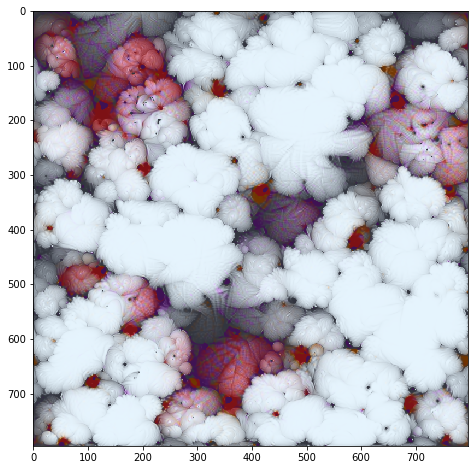

In [210]:
plt.figure(figsize=(8,8))
image = ToNumpy(out["image"])
plt.imshow(Normalize(image))

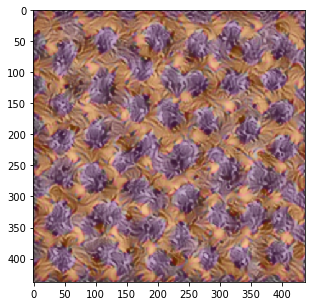

In [0]:
#factor 0.25
plt.figure(figsize=(5,5))
image = ToNumpy(out["image"])
plt.imshow(Normalize(image))

### TEMPORAL